In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

### Load the player data

In [2]:
phs_2021_1 = pd.read_csv("data/phs_2021_1.csv")
phs_2020_1 = pd.read_csv("data/phs_2020_1.csv")
phs_2020_2 = pd.read_csv("data/phs_2020_2.csv")
phs_df = pd.concat([phs_2021_1, phs_2020_1, phs_2020_2])
phs_df.head()

,start_time,esports_match_id,tournament_title,map_type,map_name,player_name,team_name,stat_name,hero_name,stat_amount
0,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,All Damage Done,All Heroes,13900.680095
1,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,Assists,All Heroes,8.000000
2,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,Average Time Alive,All Heroes,56.481102
3,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,Barrier Damage Done,All Heroes,1495.492155
4,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,Damage - Quick Melee,All Heroes,60.000000


### Data cleaning


In [3]:
# remove data with all heroes
phs_df = phs_df[phs_df["hero_name"]!="All Heroes"]
# remove data of three solo maps
phs_df = phs_df[
    (phs_df["map_name"]!="Castillo") &
    (phs_df["map_name"]!="Ecopoint: Antarctica") &
    (phs_df["map_name"]!="Necropolis")
]
# create hero and status amount dataframe
hero_player_stat_data = phs_df.groupby(["hero_name", "stat_name", "player_name"])["stat_amount"].agg(np.mean).reset_index()
hero_player_stat_data

,hero_name,stat_name,player_name,stat_amount
0,Ana,All Damage Done,AimGod,3556.073910
1,Ana,All Damage Done,Alarm,4461.771940
2,Ana,All Damage Done,Anamo,839.628085
3,Ana,All Damage Done,Architect,7795.636898
4,Ana,All Damage Done,Aztac,7922.284263
...,...,...,...,...
91935,Zenyatta,Weapon Accuracy,moth,0.188199
91936,Zenyatta,Weapon Accuracy,ryujehong,0.302635
91937,Zenyatta,Weapon Accuracy,shu,0.252649
91938,Zenyatta,Weapon Accuracy,skewed,0.196812


### K-means clustering for heroes

In [4]:
# get the shared status
hero_stats = hero_player_stat_data.groupby("hero_name")["stat_name"].agg(lambda x: set(x)).reset_index()
stats = list(hero_player_stat_data["stat_name"].unique())
for stat in stats:
    for i in range(len(hero_stats)):
        if ((stat not in hero_stats.loc[i, "stat_name"]) & (stat in stats)):
            stats[stats.index(stat)] = None
shared_hero_stats = list(filter(lambda x: x is not None, stats))
# filter out the shared status from the hero_stat_data dataframe
hero_player_shared_stat_data = hero_player_stat_data[hero_player_stat_data["stat_name"].isin(shared_hero_stats)]
hero_player_shared_stat_data

,hero_name,stat_name,player_name,stat_amount
0,Ana,All Damage Done,AimGod,3556.073910
1,Ana,All Damage Done,Alarm,4461.771940
2,Ana,All Damage Done,Anamo,839.628085
3,Ana,All Damage Done,Architect,7795.636898
4,Ana,All Damage Done,Aztac,7922.284263
...,...,...,...,...
91876,Zenyatta,Ultimates Used,moth,2.416667
91877,Zenyatta,Ultimates Used,ryujehong,3.000000
91878,Zenyatta,Ultimates Used,shu,2.705882
91879,Zenyatta,Ultimates Used,skewed,2.214286


In [5]:
hero_list = list(hero_player_shared_stat_data["hero_name"].unique())
hero_stats_array = np.zeros((len(hero_list), len(shared_hero_stats)))
for hero in hero_list:
    for stat in shared_hero_stats:
        hero_index = hero_list.index(hero)
        stat_index = shared_hero_stats.index(stat)
        hero_stats_array[hero_index][stat_index] = hero_player_shared_stat_data[
            (hero_player_shared_stat_data["hero_name"]==hero) &
            (hero_player_shared_stat_data["stat_name"]==stat)
        ]["stat_amount"].agg(np.mean)
hero_stats_array

array([[2.80301838e+03, 6.38028382e+00, 7.60077640e+01, 1.08061518e+03,
        1.70465221e+03, 3.63336943e+00, 7.69564057e+00, 2.28368176e+00,
        1.04747715e+03, 1.90463807e+03, 1.05895692e+00, 3.48510352e+00,
        2.87633031e+01, 1.03561107e+00, 2.83876048e+02, 2.42206093e+02,
        6.68979501e+00, 1.73949719e+02, 8.87677384e+00, 7.64675937e+01,
        3.13135993e+02, 1.34863470e+00, 2.97604342e+00, 3.93100123e+00],
       [1.01539426e+04, 6.00222823e+00, 7.57450750e+01, 3.44806906e+03,
        2.27097884e+03, 3.88928675e+00, 1.15681838e+01, 6.19915634e+00,
        1.56488209e+03, 6.57792195e+03, 1.27781570e+00, 4.21423030e+00,
        2.40537435e+01, 1.41094484e+00, 3.20850938e+02, 3.08098250e+02,
        1.46329865e+01, 1.68689850e+02, 8.07379988e+00, 5.99840808e+01,
        3.53037911e+02, 2.69708995e+00, 2.75783623e+00, 2.81019017e+00],
       [5.45045826e+03, 7.07180756e+00, 8.78597782e+01, 3.10368613e+03,
        2.36559013e+03, 4.02291055e+00, 9.23882622e+00, 3.0825

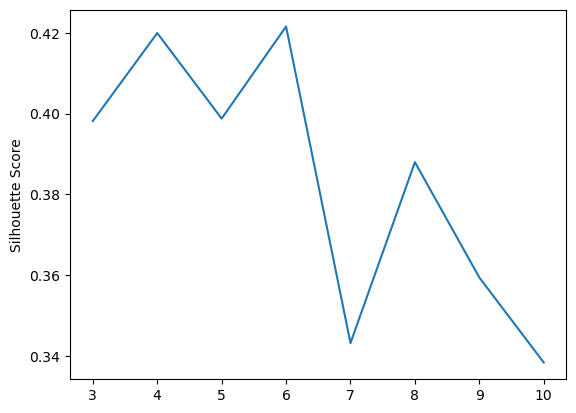

In [6]:
sil_hero = []
kmax = 10
for k in range(3, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(hero_stats_array)
    labels = kmeans.labels_
    sil_hero.append(silhouette_score(hero_stats_array, labels, metric = 'euclidean'))
#plot the silhouette score
plt.plot(range(3, kmax+1), sil_hero)
plt.ylabel('Silhouette Score')
plt.show()

### Agglomerative clustering for heroes

In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [14]:
agglo = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete").fit(hero_stats_array)

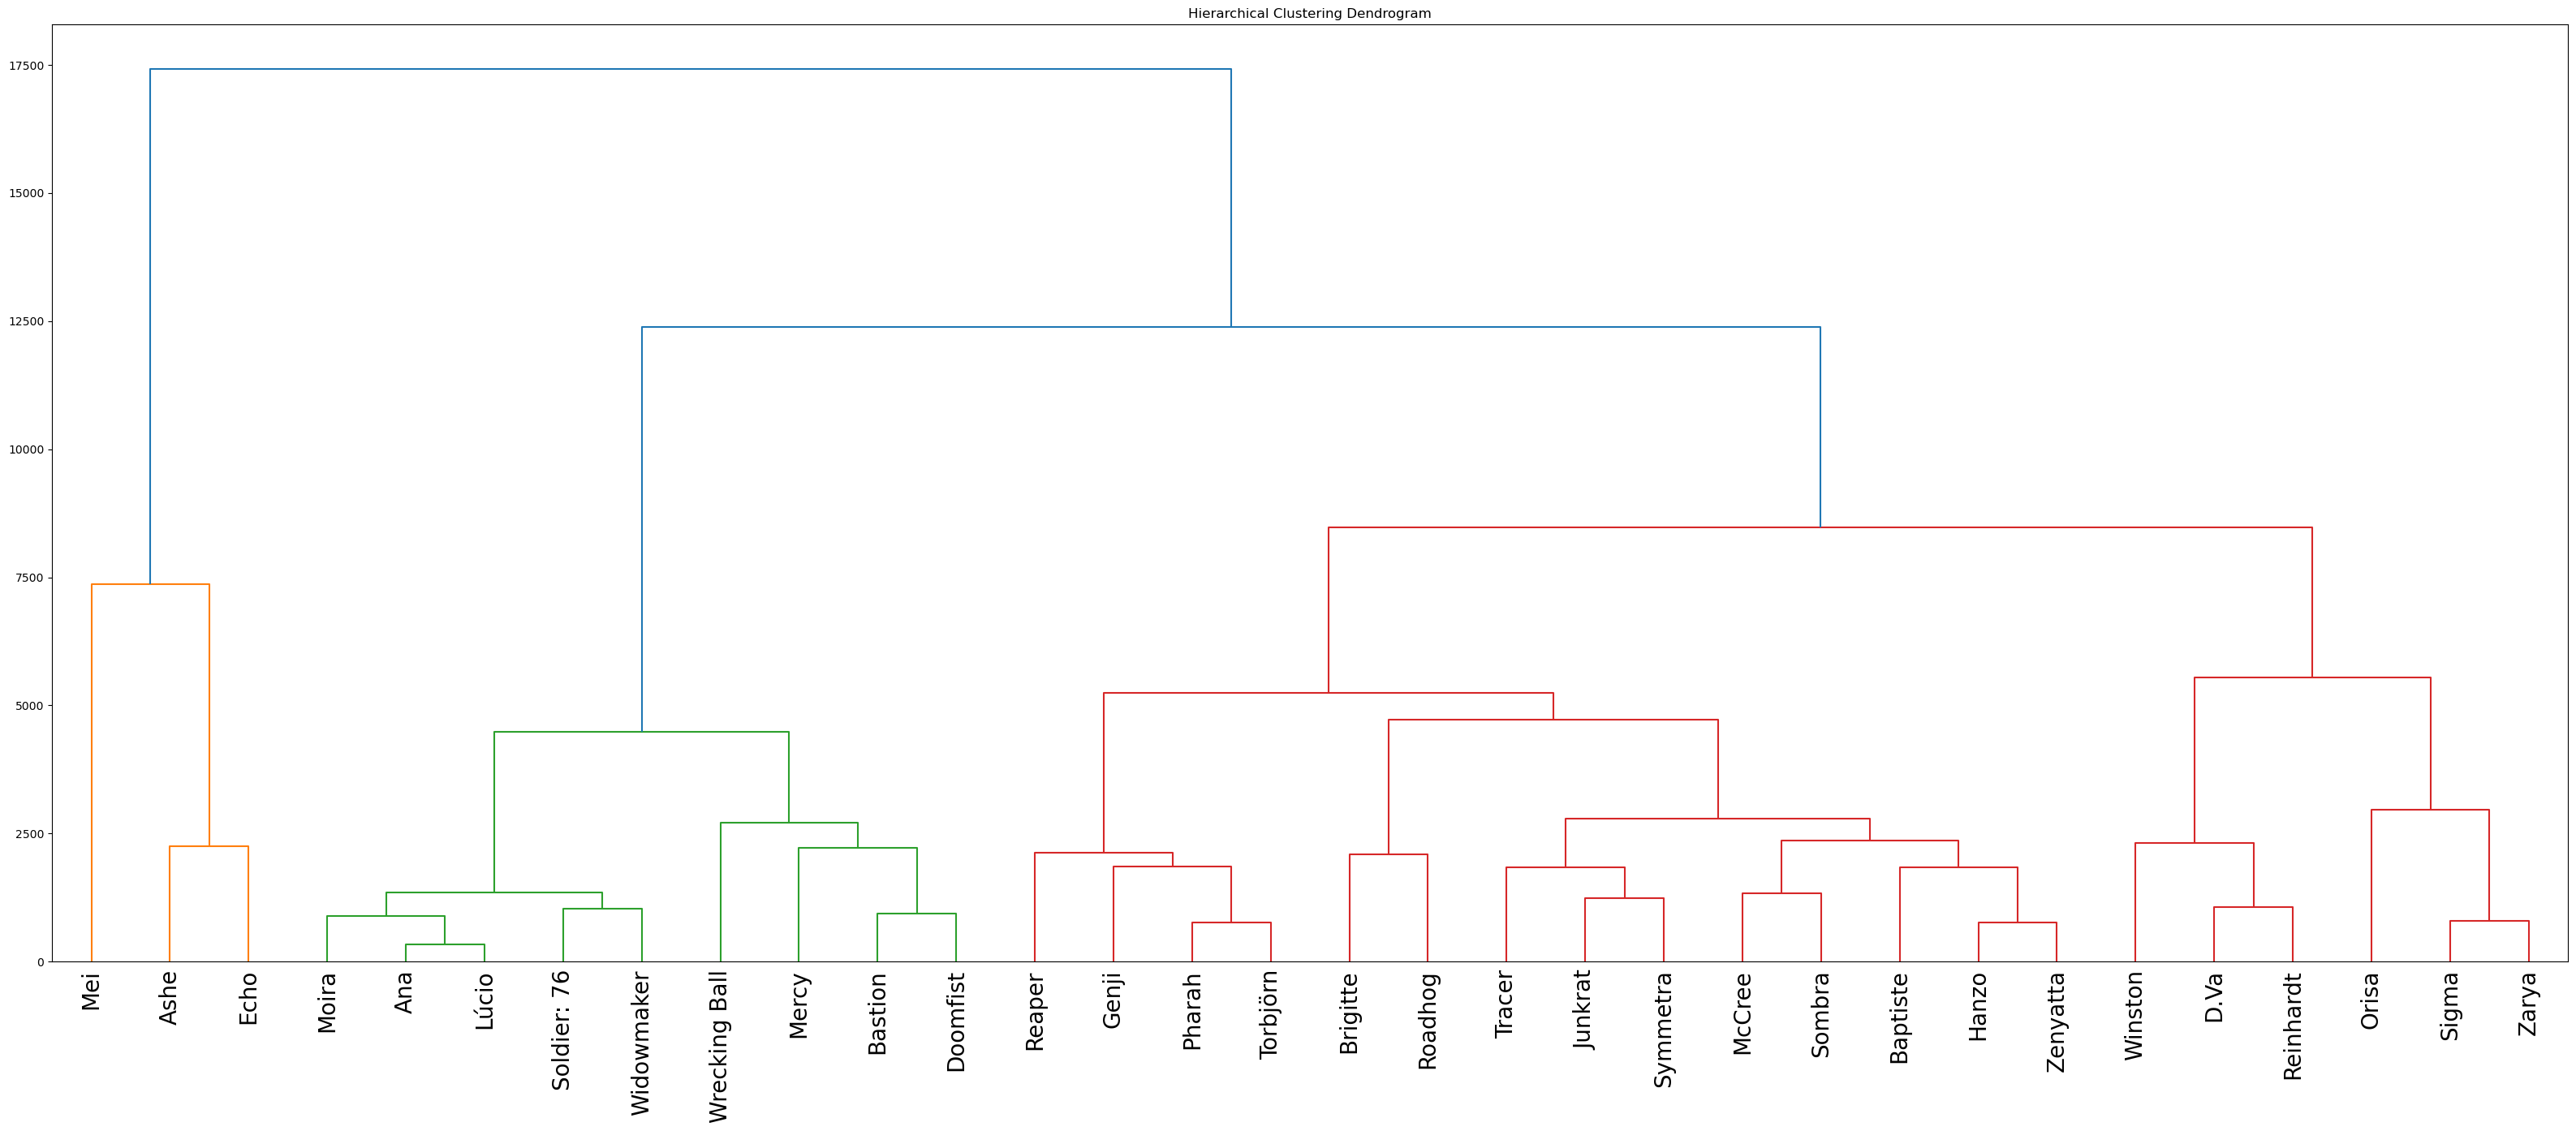

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(40, 15)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglo, labels=hero_list)
# setting the axis labels to increase font size
ax.tick_params(axis='x', which='major', labelsize=20)
plt.xticks(rotation=90)
plt.show()

### K-means clustering for players

In [7]:
# get the shared status
player_stats = hero_player_stat_data.groupby("player_name")["stat_name"].agg(lambda x: set(x)).reset_index()
stats = list(hero_player_stat_data["stat_name"].unique())
for stat in stats:
    for i in range(len(player_stats)):
        if ((stat not in player_stats.loc[i, "stat_name"]) & (stat in stats)):
            stats[stats.index(stat)] = None
shared_player_stats = list(filter(lambda x: x is not None, stats))
# filter out the shared status from the hero_stat_data dataframe
hero_player_shared_stat_data = hero_player_stat_data[hero_player_stat_data["stat_name"].isin(shared_player_stats)]
hero_player_shared_stat_data

,hero_name,stat_name,player_name,stat_amount
0,Ana,All Damage Done,AimGod,3556.073910
1,Ana,All Damage Done,Alarm,4461.771940
2,Ana,All Damage Done,Anamo,839.628085
3,Ana,All Damage Done,Architect,7795.636898
4,Ana,All Damage Done,Aztac,7922.284263
...,...,...,...,...
91824,Zenyatta,Ultimates Earned - Fractional,ryujehong,2.465808
91825,Zenyatta,Ultimates Earned - Fractional,shu,3.104670
91826,Zenyatta,Ultimates Earned - Fractional,skewed,2.204984
91827,Zenyatta,Ultimates Earned - Fractional,tobi,0.011688


In [8]:
player_list = list(hero_player_shared_stat_data["player_name"].unique())
player_stats_array = np.zeros((len(player_list), len(shared_player_stats)))
for player in player_list:
    for stat in shared_player_stats:
        player_index = player_list.index(player)
        stat_index = shared_player_stats.index(stat)
        player_stats_array[player_index][stat_index] = hero_player_shared_stat_data[
            (hero_player_shared_stat_data["player_name"]==player) &
            (hero_player_shared_stat_data["stat_name"]==stat)
        ]["stat_amount"].agg(np.mean)
player_stats_array

array([[4.34579506e+03, 7.39163503e+00, 7.07666442e+01, ...,
        1.73037813e+02, 3.56141754e+02, 3.20448405e+00],
       [5.37297335e+03, 9.14321710e+00, 8.40417489e+01, ...,
        1.95512131e+02, 4.02089643e+02, 3.53189098e+00],
       [2.83143010e+03, 4.90397703e+00, 7.78828008e+01, ...,
        2.73994285e+02, 2.88789122e+02, 2.30945868e+00],
       ...,
       [6.78872555e+03, 8.00000000e+00, 4.48299726e+01, ...,
        1.71035494e+02, 4.02012784e+02, 3.06700993e+00],
       [5.12056309e+03, 1.15000000e+01, 2.60249508e+02, ...,
        1.09998120e+02, 2.60386995e+02, 2.27376500e+00],
       [4.91507296e+03, 6.00000000e+00, 5.80575851e+01, ...,
        2.18579317e+02, 2.22559571e+02, 2.17517943e+00]])

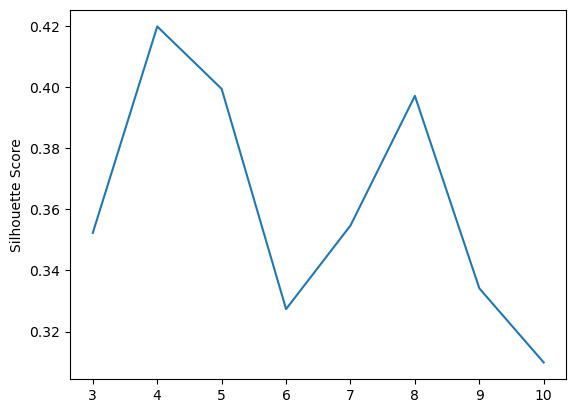

In [9]:
sil_player = []
kmax = 10
for k in range(3, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(hero_stats_array)
    labels = kmeans.labels_
    sil_player.append(silhouette_score(hero_stats_array, labels, metric = 'euclidean'))
#plot the silhouette score
plt.plot(range(3, kmax+1), sil_player)
plt.ylabel('Silhouette Score')
plt.show()